In [1]:
import matplotlib.pyplot as plt
import torch
import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms.transforms import *

In [2]:
# firts lest try a very simple vae

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, code_size):
        super(VAE, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.code = nn.Linear(hidden_size, code_size)
        self.decoder = nn.Linear(code_size, hidden_size)
        self.output = nn.Linear(hidden_size, input_size)


    def forward(self, x):
        x = self.encoder(x)
        x = self.code(x)
        x = self.decoder(x)
        x = self.output(x)
        return x

In [3]:
device = 'cuda'
dataset = MNIST(root='./data', download=True, transform=ToTensor())
test_dataset = MNIST(root='./data', download=True, transform=ToTensor(), train=False)
model = VAE(28 * 28, 128, 32).to(device)
optimizer = torch.optim.Adam(model.parameters())

In [5]:
def epoch(model, dataset):
    dataloader = DataLoader(dataset, batch_size=32)
    loss_fn = torch.nn.MSELoss()
    for image, digit in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        image = image.to(device)
        image = torch.flatten(image, -2)
        reconstructed = model(image)
        loss = loss_fn(reconstructed, image)
        loss.backward()
        optimizer.step()
for i in range(2):
    epoch(model,dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:05<00:00, 339.66it/s]


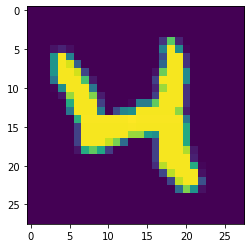

In [6]:
data = dataset[20][0].unsqueeze(0).to(device)
plt.imshow(data.squeeze(0).squeeze(0).cpu().numpy())
reconstructed = model(torch.flatten(data, -2))

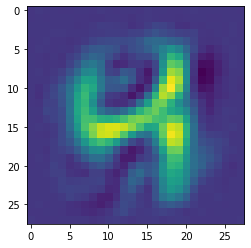

In [7]:
plt.imshow(reconstructed.view(1, -1, 28, 28).squeeze(0).squeeze(0).detach().cpu().numpy())

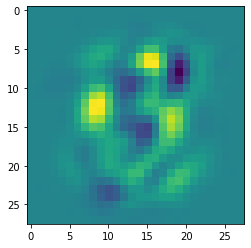

In [7]:
random_code = torch.rand(32).to(device)

reconstructed = model.decoder(random_code)
reconstructed = model.output(reconstructed)
plt.imshow(reconstructed.view(-1, 28, 28).squeeze(0).detach().cpu().numpy())

In [12]:
#from torch.distributions.normal import Normal
from torch.distributions.kl import Normal
from torch.distributions import kl_divergence

# now a convolutional vae


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)

class CVAE(nn.Module):
    def __init__(self, input_dim, dim, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Conv2d(dim, z_dim * 2, 3, 1, 0),
            nn.BatchNorm2d(z_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, dim, 3, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 5, 1, 0),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, dim, 4, 2, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(dim, input_dim, 4, 2, 1),
            nn.Tanh()
        )

        self.apply(weights_init)

    def forward(self, x):
        mu, logvar = self.encoder(x).chunk(2, dim=1)

        # repamatrization trick
        q_z_x = Normal(mu, logvar.mul(.5).exp())
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        kl_div = kl_divergence(q_z_x, p_z).sum(1).mean()

        x_tilde = self.decoder(q_z_x.rsample())
        return x_tilde, kl_div

In [15]:
cvae = CVAE(input_dim=1, dim=256, z_dim=128).to(device)
opt = torch.optim.Adam(cvae.parameters(), lr=1e-3, amsgrad=True)

In [17]:
def epoch(model, dataset, optimizer):
    dataloader = DataLoader(dataset, batch_size=32)
    loss_fn = torch.nn.MSELoss()
    pbar = tqdm.tqdm(dataloader)
    for image, digit in pbar:
        optimizer.zero_grad()
        image = image.to(device)
        reconstructed = model(image)[0]
        loss = loss_fn(reconstructed, image)
        pbar.set_description(str(loss))
        loss.backward()
        optimizer.step()
for i in range(5):
    epoch(cvae,dataset, opt)

tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:16<00:00, 117.04it/s]
tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:16<00:00, 116.92it/s]
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:17<00:00, 107.92it/s]
tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:17<00:00, 108.66it/s]
tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:15<00:0

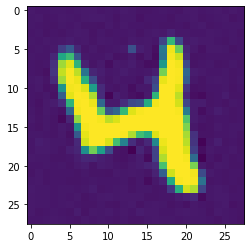

In [18]:
cvae.eval()
data = dataset[20][0].unsqueeze(0).to(device)
plt.imshow(data.squeeze(0).squeeze(0).cpu().numpy())
reconstructed = cvae(data)[0]
plt.imshow(reconstructed.view(1, -1, 28, 28).squeeze(0).squeeze(0).detach().cpu().numpy())

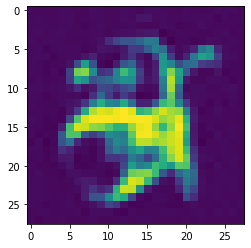

In [19]:
mu, logvar = cvae.encoder(data).chunk(2, dim=1)
q_z_x = Normal(torch.rand_like(mu), torch.rand_like(logvar).mul(.5).exp())
x_tilde = cvae.decoder(q_z_x.rsample())
plt.imshow(x_tilde.view(1, -1, 28, 28).squeeze(0).squeeze(0).detach().cpu().numpy())

In [9]:
batch_size = 128
num_training_updates = 15000

input_dim = 3
num_hiddens = 256
num_residual_hiddens = 32
num_residual_layers = 8

embedding_dim = 128
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [10]:
from torchvision import datasets
import canon_vqvae
import vqvae
import importlib

importlib.reload(vqvae)
importlib.reload(canon_vqvae)

the_vqvae = vqvae.VQVAE(input_dim=input_dim, hidden_dim=num_hiddens, embedding_dim=embedding_dim, codebook_size=num_embeddings, num_residual_layer=num_residual_layers, dim_residual_layer=num_residual_hiddens).to(device)

# print(the_vqvae)
opt = torch.optim.Adam(the_vqvae.parameters(), lr=learning_rate, amsgrad=True)

dataset = datasets.ImageFolder(root='/home/lleonard/Documents/datasets/img_align_celeba/', transform=Compose([
    Resize((128, 128)),
    ToTensor(),
    #Normalize(0.5, 0.5, 0.5)
]))


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=3e-3, total_steps=num_training_updates)

from torch.utils.tensorboard import SummaryWriter



def epoch(model, dataloader, optimizer):
    loss_fn = torch.nn.MSELoss()
    pbar = tqdm.tqdm(range(num_training_updates), ncols=100)
    tb_writer = SummaryWriter('./logs')

    data_iterator = iter(dataloader)
    for step in pbar:
        try:
            (image, _) = next(data_iterator)
        except Exception as e:
            data_iterator = iter(dataloader)
            continue
        optimizer.zero_grad()
        image = image.to(device)
        commit_loss, reconstructed = model(image)
        loss = commit_loss + loss_fn(reconstructed, image)
        tb_writer.add_scalar('loss', loss, step)
        if step % 100:
            tb_writer.add_image(ToPILImage()(reconstructed[0]), 'reconstructed', step)
            tb_writer.add_image(ToPILImage()(image[0]), 'reconstructed', step)
        pbar.set_description(str(round(loss.detach().item(), 4)))
        loss.backward()
        optimizer.step()
        scheduler.step()

the_vqvae.train()
epoch(the_vqvae, dataloader, opt)

  0%|                                                                     | 0/15000 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 23.70 GiB total capacity; 20.12 GiB already allocated; 124.25 MiB free; 20.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

torch.Size([1, 3, 64, 64])


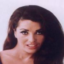

In [213]:
the_vqvae.eval()
data = dataset[10][0].unsqueeze(0).to(device)
#plt.imshow(data.squeeze(0).squeeze(0).cpu().numpy())
print(data.shape)
ToPILImage()(data.squeeze(0))

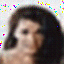

In [214]:
reconstructed = the_vqvae(data)[1]
reconstructed = reconstructed.detach().squeeze(0)
ToPILImage()(reconstructed.squeeze(0))

torch.Size([1, 8, 8])


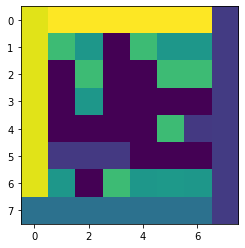

In [199]:
latents, latents_indices = the_vqvae.encode(data)
print(latents_indices.shape)
plt.imshow(latents_indices.squeeze(0).detach().cpu().numpy())

torch.Size([1, 7, 7, 128])


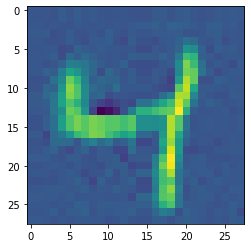

In [129]:
print(latents.shape)
latents[0, 0, 0] = the_vqvae.vq._codebook.embed[1]

latents[0, 2, 3] = the_vqvae.vq._codebook.embed[1]
plt.imshow(the_vqvae.decode(latents).squeeze(0).squeeze(0).detach().cpu().numpy())

In [ ]:
from torch.nn.functional import embedding


random_latents = embedding(torch.randint(0, 512, (7, 7)).to(device), vqvae.vq._codebook.embed)
plt.imshow(vqvae.decode(random_latents.unsqueeze(0)).squeeze(0).squeeze(0).detach().cpu().numpy())

In [ ]:
print('x' * 255)